In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from functools import reduce
from pandasql import sqldf
import matplotlib as mpl
import matplotlib.pyplot as plt

pysqldf = lambda q: sqldf(q, globals())

import os

path = os.getcwd() + r'/archive' # use your path
# print(path)
# all_files = glob.glob(os.path.join(path , "/*.csv"))
# print(all_files)


directory = ""
li = []

for filename in sorted(os.listdir(path)):
    if(filename == "merged_data.csv"):
        continue
    file = os.path.join(path, filename)
    df = pd.read_csv(file)
    li.append(df)
print(len(li))

9


In [2]:
df_customers, df_geolocation, df_order_items, df_order_payments, df_order_reviews, df_orders, df_products, df_sellers, df_category_name_translation = li
print(df_customers)

                            customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  
0  

In [3]:
order_customers = [df_orders, df_customers]
merged_orders_customers = reduce(lambda left, right: pd.merge(left, right, on=["customer_id"], how="inner"), order_customers)
order_customers_items = [merged_orders_customers, df_order_items]
merged_orders_customers_items = reduce(lambda left, right: pd.merge(left, right, on=["order_id"], how='inner'), order_customers_items)
order_customers_items_products = [merged_orders_customers_items, df_products]
merged_orders_customers_items_products = reduce(lambda left, right: pd.merge(left, right, on=["product_id"], how='inner'), order_customers_items_products)
order_customers_items_products_names = [merged_orders_customers_items_products, df_category_name_translation]
merged_orders_customers_items_products_names = reduce(lambda left, right: pd.merge(left, right, on=["product_category_name"], how='inner'), order_customers_items_products_names)


In [27]:
df_aggregate_product = pd.DataFrame(merged_orders_customers_items_products_names['product_id'].unique(), columns=["product_id"])

q = pysqldf("""
    SELECT product_id, AVG(review_score) as average_score FROM merged_orders_customers_items_products_names NATURAL JOIN df_order_reviews GROUP BY 1
    HAVING COUNT(product_id) > 50
""")
df_aggregate_product = reduce(lambda left, right: pd.merge(left, right, on=["product_id"], how="inner"), [df_aggregate_product, q])
print(df_aggregate_product)
q = pysqldf("""
    SELECT product_id, COUNT(product_id) as times_bought FROM merged_orders_customers_items GROUP BY product_id
""")
df_aggregate_product = reduce(lambda left, right: pd.merge(left, right, on=["product_id"], how="inner"), [df_aggregate_product, q])



                           product_id  average_score
0    42a2c92a0979a949ca4ea89ec5c7b934       4.000000
1    e9a69340883a438c3f91739d14d3a56d       4.000000
2    30ac6df06dc59ad72cf2f158fc2d904c       3.944444
3    d696750e550fd0f733979dd7e5dff921       4.526316
4    5a6e53c3b4e8684b13388d6aa4afdf12       4.164384
..                                ...            ...
163  35afc973633aaeb6b877ff57b2793310       3.820359
164  0aabfb375647d9738ad0f7b4ea3653b1       4.204225
165  6c3effec7c8ddba466d4f03f982c7aa3       3.894737
166  cd48f265a63e13b762601f5f794c5fca       4.236559
167  4fe644d766c7566dbc46fb851363cb3b       3.754717

[168 rows x 2 columns]


Text(0, 0.5, 'Times Bought')

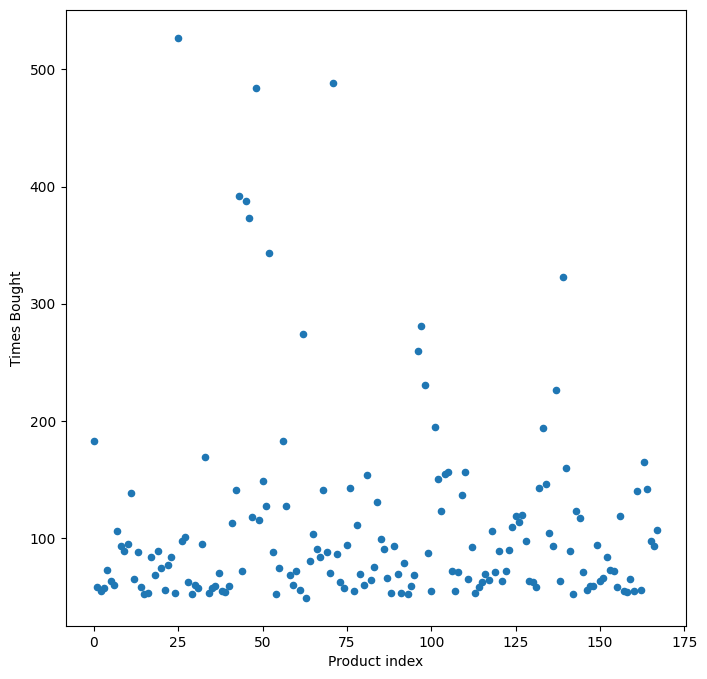

In [28]:
products_bought_graph = df_aggregate_product.iloc[:500].reset_index().plot(x='index', y='times_bought', kind='scatter', figsize=(8,8))
products_bought_graph.set_xlabel("Product index")
products_bought_graph.set_ylabel("Times Bought")


Text(0, 0.5, 'Review Score')

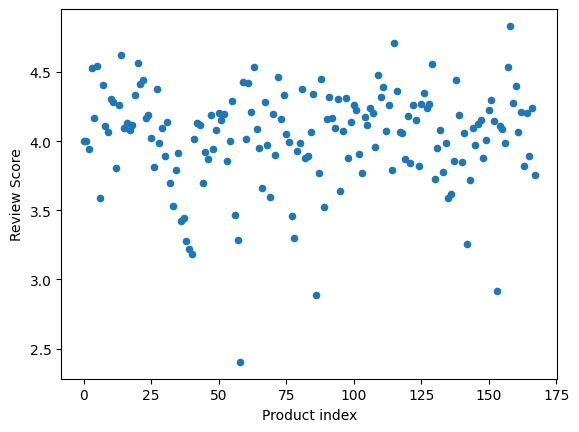

In [29]:

products_review_graph = df_aggregate_product.iloc[:500].reset_index().plot(x='index', y='average_score', kind='scatter')
products_review_graph.set_xlabel("Product index")
products_review_graph.set_ylabel("Review Score")

In [99]:
merged_orders_customers_items_products_names = merged_orders_customers_items_products_names.drop(columns=["order_status", "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date", "customer_zip_code_prefix", "customer_city", "order_item_id", "seller_id", "shipping_limit_date", "price", "freight_value", "product_category_name", "product_name_lenght", "product_description_lenght", "product_photos_qty", "product_weight_g", "product_length_cm", "product_width_cm", "product_height_cm"])
merged_orders_customers_items_products_names.to_csv(os.path.join(path, "merged_data.csv"), index=False)